In [10]:
import pandas as pd
import os
from data_preprocessing import preprocess_dataframe
from descriptor_calculation import descriptor_cal
# from descriptor_calculation import smiles_solvent_descriptors
from train_func import train_models
import shutil
import os
import deepchem as dc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

In [11]:
df = pd.read_csv("All Properties with Finguprints_3.csv")

In [12]:
df.dtypes

Sr.No                     int64
Smiles                   object
Solvent                  object
AbsorptioMax (nm)       float64
EmissionMax (nm)        float64
Fluorescent labeling     object
Total Molweight         float64
molFormula               object
cLogP                   float64
cLogS                   float64
H-Acceptors               int64
H-Donors                  int64
Total Surface Area      float64
Relative PSA            float64
Polar Surface Area      float64
Druglikeness            float64
Rotatable Bonds           int64
Weiner                  float64
dtype: object

In [13]:
df['Smiles'] = df['Smiles'].astype(str)

In [14]:
df.dtypes

Sr.No                     int64
Smiles                   object
Solvent                  object
AbsorptioMax (nm)       float64
EmissionMax (nm)        float64
Fluorescent labeling     object
Total Molweight         float64
molFormula               object
cLogP                   float64
cLogS                   float64
H-Acceptors               int64
H-Donors                  int64
Total Surface Area      float64
Relative PSA            float64
Polar Surface Area      float64
Druglikeness            float64
Rotatable Bonds           int64
Weiner                  float64
dtype: object

In [15]:
PATH = "All Properties with Finguprints_3.csv"
descriptor_list = ["Morgan fingerprints","MACCSKeysFingerprint","RDKitDescriptors"] 
TARGET = "AbsorptioMax (nm)"

In [16]:
df = pd.read_csv(PATH)
df.head()

,Sr.No,Smiles,Solvent,AbsorptioMax (nm),EmissionMax (nm),Fluorescent labeling,Total Molweight,molFormula,cLogP,cLogS,H-Acceptors,H-Donors,Total Surface Area,Relative PSA,Polar Surface Area,Druglikeness,Rotatable Bonds,Weiner
0,1,N#Cc1cc2ccc(O)cc2oc1=O,O,355.0,410.00,Yes,187.154,C10H5NO3,0.8375,-2.346,4,1,140.28,0.354290,70.32,-4.14950,0,288.0
1,2,N#Cc1cc2ccc([O-])cc2oc1=O,O,408.0,450.00,Yes,186.146,C10H4NO3,-0.7405,-2.346,4,0,141.46,0.359680,73.15,-4.14950,0,288.0
2,3,CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c...,ClC(Cl)Cl,526.0,535.00,Yes,1061.540,C73H92N2O4,24.1650,-27.266,6,0,933.68,0.063469,74.76,-20.14900,39,55900.0
3,4,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,CC#N,514.0,553.72,Yes,350.420,C23H12NOS,4.5981,-7.337,2,0,249.23,0.183000,64.19,0.73261,1,1522.0
4,5,[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34,CS(C)=O,524.0,555.00,Yes,350.420,C23H12NOS,4.5981,-7.337,2,0,249.23,0.183000,64.19,0.73261,1,1522.0


In [17]:
df.shape

(32303, 18)

In [18]:
df.drop(df.index[df['Solvent'] == 'gas'], inplace = True)

In [19]:
df.shape

(32302, 18)

In [20]:
df.shape

(32302, 18)

In [21]:
# Select only Fluoroscent molecules, since solvents data is available for Fluroscent pnly
df = df.loc[df['Fluorescent labeling'] == 'Yes']
df.shape

(15902, 18)

### Calculate descriptors

In [22]:
def smiles_solvent_descriptors(df,desc,TARGET):
  try:
      dataset_original=df
      
      # morgan
      if desc == "Morgan fingerprints": 
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.CircularFingerprint(radius=3, size=1024)
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)

          y = dataset_original[TARGET]

          return x, y
      # rdkit

      elif desc == 'Mordred descriptors':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.MordredDescriptors(ignore_3D = True)
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          
          y = dataset_original[TARGET]

          return x, y

      elif desc == 'MACCSKeysFingerprint':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.MACCSKeysFingerprint()
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          y = dataset_original[TARGET]

          return x, y

      elif desc == 'RDKitDescriptors':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.RDKitDescriptors(use_fragment=True, ipc_avg=True)
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          x.replace([np.inf, -np.inf], np.nan, inplace=True)
          x.fillna(0, inplace=True)
          scaler = StandardScaler()
          x = pd.DataFrame(data=scaler.fit_transform(x))
          y = dataset_original[TARGET]

          return x, y

      elif desc == 'PubChemFingerprint':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.PubChemFingerprint()
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          y = dataset_original[TARGET]

          return x, y

      else:
          pass

  except Exception as e:
      raise e


In [23]:
TARGET = "Abso"

In [24]:
descriptor_list

['Morgan fingerprints', 'MACCSKeysFingerprint', 'RDKitDescriptors']

In [25]:
for descriptor in descriptor_list:
    # Call the descriptor_cal function to get X and Y
    X, Y = smiles_solvent_descriptors(df, descriptor,TARGET)
    
    # Create a folder for the descriptor if it doesn't exist
    folder_path = os.path.join(os.getcwd(),"LambdaMaxDesc", f"{descriptor}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Save the X and Y DataFrames to separate CSV files in the folder
    x_file_path = os.path.join(folder_path, 'X.csv')
    y_file_path = os.path.join(folder_path, 'Y.csv')
    X.to_csv(x_file_path, index=False)
    Y.to_csv(y_file_path, index=False)

    print(f"X and y saved for {descriptor}")
    print(f"descriptors shape: {X.shape}")

KeyError: 'Abso'

### Train Models

In [ ]:
def train_regression(X,y,PATH):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a dictionary of regression models
    models = {
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'ElasticNet Regression': ElasticNet(),
        'Decision Tree Regression': DecisionTreeRegressor(),
        'Random Forest Regression': RandomForestRegressor(),
        'Support Vector Regression': SVR(),
        'K-Nearest Neighbors Regression': KNeighborsRegressor()
    }

    # Define a list of evaluation metrics to evaluate the models
    metrics = [mean_absolute_error, mean_squared_error, r2_score]

    # Create a results folder if it doesn't exist
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    # Loop through each model, train it, and evaluate its performance
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results = {}
        for metric in metrics:
            metric_name = metric.__name__
            results[metric_name] = metric(y_test, y_pred)
        results_df = pd.DataFrame.from_dict(results, orient='index', columns=[name])
        results_df.to_csv(f'{PATH}/{name}.csv')


In [ ]:
# Define the path to the folder containing subfolders
path_to_descriptors = "LambdaMaxDesc"
results_folder = "LambdaMaxScores"
if os.path.exists(results_folder):
    shutil.rmtree(results_folder)


# Loop over each subfolder
for subfolder_name in os.listdir(path_to_descriptors):
    
    # Define the path to the X.csv and Y.csv files for the current subfolder
    path_to_X = os.path.join(path_to_descriptors, subfolder_name, "X.csv")
    path_to_Y = os.path.join(path_to_descriptors, subfolder_name, "Y.csv")
    
    # Load the X.csv and Y.csv files as dataframes
    X = pd.read_csv(path_to_X)
    Y = pd.read_csv(path_to_Y)
    
    # Call the train_models function with X, Y, and the current subfolder name as the PATH argument
    train_regression(X, Y, f"{results_folder}/{subfolder_name}")


/var/folders/nf/xdcscmx50n3ccqpvd73zgys00000gn/T/ipykernel_20449/2790036193.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/ganeshjadhav/opt/anaconda3/envs/ML-for-LSD1-main/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/nf/xdcscmx50n3ccqpvd73zgys00000gn/T/ipykernel_20449/2790036193.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/ganeshjadhav/opt/anaconda3/envs/ML-for-LSD1-main/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector 

### Plot results

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT):
        
    # Define a list to store the accuracy values for each csv file
    accuracy_values = []

    # Loop through each subfolder in folder1
    for subfolder in os.listdir(SCORES_FOLDER):
        subfolder_path = os.path.join(SCORES_FOLDER, subfolder)
        
        # Loop through each csv file in the subfolder
        for csv_file in os.listdir(subfolder_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(subfolder_path, csv_file)
                
                # Read the csv file into a pandas dataframe
                df = pd.read_csv(csv_path, index_col=[0])
                
                # Extract the accuracy value from the dataframe and append it to the list
                accuracy_value = df.loc[METRIC_TO_PLOT].values[0]
                accuracy_values.append((subfolder, csv_file[:-4], accuracy_value)) # Remove the last 4 characters (i.e. ".csv") from the csv file name

    # Convert the accuracy values list to a pandas dataframe
    df_accuracy = pd.DataFrame(accuracy_values, columns=['Subfolder', 'CSV File', METRIC_TO_PLOT])

    # Pivot the dataframe to have Subfolder as the index, CSV File as the columns, and Accuracy as the values
    df_accuracy_pivot = df_accuracy.pivot(index='Subfolder', columns='CSV File', values=METRIC_TO_PLOT)

    # Create a plot of the accuracy values
    plt.figure(figsize=(10, 5))
    for csv_file in df_accuracy_pivot.columns:
        plt.plot(df_accuracy_pivot.index, df_accuracy_pivot[csv_file], label=csv_file[:]) # Remove the last 4 characters (i.e. ".csv") from the csv file name
    plt.xlabel('Subfolder')
    plt.ylabel(METRIC_TO_PLOT)
    plt.legend()

    # Get the current date and time and format it for the filename
    now = datetime.datetime.now()

    # Define the path and filename for the plot
    plot_path = f'{SCORES_FOLDER[:-6]}plots'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
        
    plot_name = os.path.join(plot_path, METRIC_TO_PLOT)

    # Save the plot
    plt.savefig(plot_name)

    # Show the plot
    plt.show()

    print(f"Compairison plots saved at: {plot_path}")

    return df_accuracy


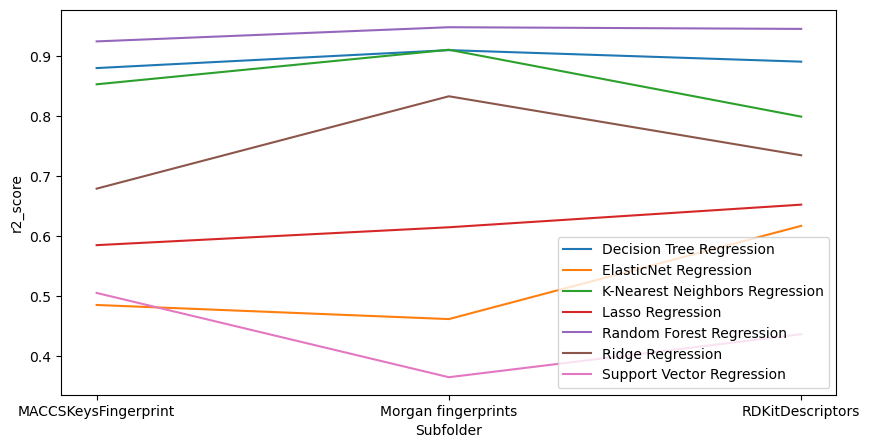

Compairison plots saved at: LambdaMaxplots


,Subfolder,CSV File,r2_score
0,MACCSKeysFingerprint,Support Vector Regression,0.505404
1,MACCSKeysFingerprint,K-Nearest Neighbors Regression,0.853002
2,MACCSKeysFingerprint,Lasso Regression,0.585026
3,MACCSKeysFingerprint,Decision Tree Regression,0.880046
4,MACCSKeysFingerprint,Ridge Regression,0.679154
5,MACCSKeysFingerprint,ElasticNet Regression,0.485338
6,MACCSKeysFingerprint,Random Forest Regression,0.924479
7,RDKitDescriptors,Support Vector Regression,0.436670
8,RDKitDescriptors,K-Nearest Neighbors Regression,0.799126
9,RDKitDescriptors,Lasso Regression,0.652476


In [ ]:
SCORES_FOLDER = "LambdaMaxScores"
METRIC_TO_PLOT = "r2_score"
plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT)